# MNIST Diffusion Model

In this section, we apply the same diffusion model framework to the MNIST dataset. Since MNIST consists
of images, we use convolutional architectures (and residual blocks) for improved performance.

**Key Points:**
- **Architecture:** We use ConvNets with residual connections and a time embedding.
- **Data Loading:** The `generate_mnist` function provides a batch of MNIST images normalized to [-1, 1].
- **Your Task:** Carefully study the architecture and complete the training, reverse process, and sample generation.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torchvision
import math

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


## Data Generation for MNIST

This function downloads MNIST (if not present) and returns a batch of MNIST images with proper normalization:
- **Normalization:** We normalize to [-1, 1] so that the diffusion noise scales work similarly to our previous examples.

In [2]:
def generate_mnist(n_samples=1000):
    """
    Generate MNIST samples, matching the interface of generate_swiss_roll.

    Args:
        n_samples: Number of samples to generate.

    Returns:
        torch.Tensor of shape (n_samples, 1, 28, 28)
    """
    # Define transformation: convert to tensor and normalize to [-1, 1]
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )

    # Download MNIST dataset if needed
    dataset = torchvision.datasets.MNIST(
        "./data", train=True, download=True, transform=transform
    )

    # Create a dataloader to sample n_samples randomly
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=n_samples, shuffle=True, drop_last=True
    )

    # Get a single batch of images and ignore the labels
    images, _ = next(iter(dataloader))
    return images


# Test the data generator:
# sample_images = generate_mnist(16)
# print(sample_images.shape)  # Expected: [16, 1, 28, 28]


## Time Embedding

We reuse the same time embedding module from the Swiss Roll example.

In [3]:
class TimeEmbedding(nn.Module):
    """Time embedding layer: embeds scalar timesteps into a higher-dimensional space."""

    def __init__(self, dim):
        super().__init__()
        self.embed = nn.Sequential(
            nn.Linear(1, dim),  # Transform from 1 to hidden dimension.
            nn.GELU(),
            nn.Linear(dim, dim),  # Map into final embedding size.
        )

    def forward(self, t):
        t = t.unsqueeze(-1).float()  # Reshape (batch,) -> (batch, 1)
        return self.embed(t)


## Residual Block for ConvNets

This block uses two convolutional layers with BatchNorm and GELU activation. Residual connections (and
proper scaling) are added optionally.


In [4]:
class ResBlock(nn.Module):
    """Residual block with Conv layers for the MNIST diffusion model."""

    def __init__(self, in_c, out_c, is_res=False):
        super().__init__()
        self.is_res = is_res
        self.same_c = in_c == out_c
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),  # Convolution layer
            nn.BatchNorm2d(out_c),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.GELU(),
        )

    def forward(self, x):
        x1 = self.conv1(x)  # First conv block
        x2 = self.conv2(x1)  # Second conv block
        if self.is_res:
            # Use a residual connection
            if self.same_c:
                out = x + x2
            else:
                out = x1 + x2
            return out / math.sqrt(2)  # Scale residual output
        return x2

## Diffusion Model with ConvNets for MNIST

The DiffusionModel below is updated to use convolutional layers, downsampling (via strided convolutions),
and upsampling (using transposed convolutions) along with skip-connections.


In [5]:
class DiffusionModel(nn.Module):
    """Diffusion model for MNIST with ConvNets, residual blocks, and time embedding."""

    def __init__(self, hidden_dim=128):
        super().__init__()

        self.time_embed = TimeEmbedding(hidden_dim)

        # Initial convolution transforms the input image channels into hidden_dim channels.
        self.input_conv = ResBlock(in_c=1, out_c=hidden_dim, is_res=True)

        # Downsampling layers (using convolutions with stride 2)
        self.down1 = nn.Sequential(
            ResBlock(hidden_dim, hidden_dim),
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.GELU(),
        )

        self.down2 = nn.Sequential(
            ResBlock(hidden_dim, hidden_dim),
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.GELU(),
        )

        # Bottleneck residual block
        self.bottleneck = ResBlock(hidden_dim, hidden_dim, is_res=True)

        # Upsampling with transpose convolutions and skip connections
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.GELU(),
            ResBlock(hidden_dim, hidden_dim, is_res=True),
        )

        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.GELU(),
            ResBlock(hidden_dim, hidden_dim, is_res=True),
        )

        # Final convolution to map features back to one channel.
        self.output = nn.Conv2d(hidden_dim * 2, 1, 3, padding=1)

    def forward(self, x, t):
        # Compute time embedding and reshape to add spatial dimensions.
        t_emb = self.time_embed(t)
        t_emb = t_emb.view(-1, t_emb.shape[1], 1, 1)

        # Initial convolution with skip connection
        x1 = self.input_conv(x)
        x1 = x1 + t_emb  # Add time information

        # Downsample with added time embedding at each stage.
        x2 = self.down1(x1)
        x2 = x2 + t_emb
        x3 = self.down2(x2)
        x3 = x3 + t_emb

        # Bottleneck transformation
        x3 = self.bottleneck(x3)

        # Upsample, concatenating skip connections.
        x = self.up2(torch.cat([x3, x3], dim=1))  # Using a dummy skip here
        x = self.up1(torch.cat([x, x2], dim=1))

        # Final output using skip connection from input
        x = self.output(torch.cat([x, x1], dim=1))
        return x


## Diffusion Scheduler

This scheduler is identical to our previous example. It defines the forward (diffuse) and reverse processes.


In [6]:
class DiffusionScheduler:
    """Noise scheduler for the diffusion model."""

    def __init__(self, num_timesteps=1000, device="cpu"):
        self.num_timesteps = num_timesteps
        self.device = device

        # Define a beta schedule linearly spaced between 1e-4 and 0.02
        self.betas = torch.linspace(1e-4, 0.02, num_timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)

        # Precompute useful square roots for the forward process.
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)

        # Additional parameters for the reverse process.
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        alphas_cumprod_prev = torch.cat(
            [torch.ones(1).to(device), self.alphas_cumprod[:-1]]
        )
        self.posterior_variance = (
            self.betas * (1.0 - alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )

    def diffuse(self, x_0, t):
        """Add noise to the data at timestep t."""
        noise = torch.randn_like(x_0)
        # Reshape scales to match image dimensions
        sqrt_alpha_t = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
        x_t = sqrt_alpha_t * x_0 + sqrt_one_minus_alpha_t * noise
        return x_t, noise

    def reverse_step(self, x_t, t, predicted_noise):
        """Single reverse process step using the provided formula."""
        alpha = self.alphas[t]
        alpha_bar = self.alphas_cumprod[t]
        if t > 0:
            noise = torch.randn_like(x_t)
        else:
            noise = 0
        x_t_minus_1 = (1 / torch.sqrt(alpha)) * (
            x_t - (1 - alpha) / torch.sqrt(1 - alpha_bar) * predicted_noise
        ) + torch.sqrt(self.betas[t]) * noise
        return x_t_minus_1

## Training the MNIST Diffusion Model

In this cell, we define the training loop for the MNIST diffusion model. Notice that the training
procedure is very similar to the Swiss Roll example. The key differences are:
- **Model Architecture:** We use the ConvNet-based DiffusionModel.
- **Data:** We work with 28×28 images which have one channel.

**Your Task:**  
Try to understand the provided code. You are also encouraged to experiment with additional improvements
(e.g., using a learning rate scheduler, customizing loss functions, etc.).

Training Diffusion:   0%|          | 0/4000 [00:00<?, ?it/s]

Failed to download (trying next):
HTTP Error 404: Not Found




  0%|          | 0.00/9.91M [00:00<?, ?B/s]
  0%|          | 32.8k/9.91M [00:00<00:53, 183kB/s]
  1%|          | 65.5k/9.91M [00:00<00:54, 179kB/s]
  1%|▏         | 131k/9.91M [00:00<00:36, 265kB/s] 
  2%|▏         | 229k/9.91M [00:00<00:25, 375kB/s]
  5%|▍         | 492k/9.91M [00:00<00:12, 762kB/s]
  9%|▉         | 918k/9.91M [00:01<00:06, 1.30MB/s]
 19%|█▊        | 1.84M/9.91M [00:01<00:03, 2.53MB/s]
 32%|███▏      | 3.15M/9.91M [00:01<00:01, 4.03MB/s]
 59%|█████▉    | 5.83M/9.91M [00:01<00:00, 7.40MB/s]
100%|██████████| 9.91M/9.91M [00:01<00:00, 5.45MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found




  0%|          | 0.00/28.9k [00:00<?, ?B/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found




  0%|          | 0.00/1.65M [00:00<?, ?B/s]
  2%|▏         | 32.8k/1.65M [00:00<00:08, 186kB/s]
  4%|▍         | 65.5k/1.65M [00:00<00:08, 183kB/s]
  8%|▊         | 131k/1.65M [00:00<00:05, 265kB/s] 
 14%|█▍        | 229k/1.65M [00:00<00:03, 374kB/s]
 30%|██▉       | 492k/1.65M [00:00<00:01, 761kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found




100%|██████████| 4.54k/4.54k [00:00<00:00, 8.40MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Training Diffusion: 100%|██████████| 4000/4000 [17:17<00:00,  3.85it/s, loss=0.0265]


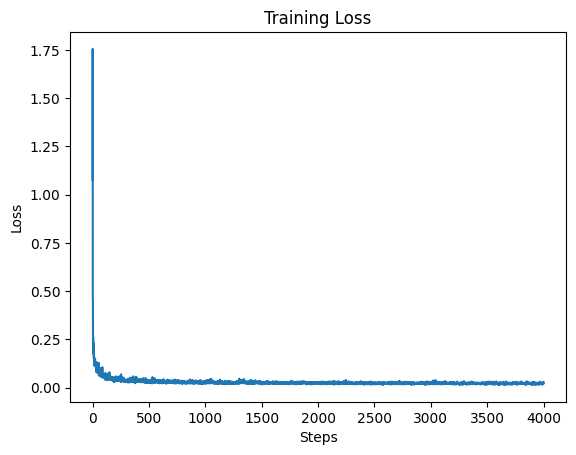

In [7]:
def train_diffusion(n_steps=10000, batch_size=128, lr=1e-3):
    """Train the diffusion model on MNIST data."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize MNIST diffusion model with convolutional architecture.
    model = DiffusionModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Initialize noise scheduler.
    scheduler = DiffusionScheduler(num_timesteps=1500, device=device)

    losses = []
    pbar = tqdm(range(n_steps), desc="Training Diffusion")

    for step in pbar:
        # Get a batch of MNIST images.
        x_0 = generate_mnist(batch_size).to(device)
        # Sample random timesteps for the batch.
        t = torch.randint(0, scheduler.num_timesteps, (x_0.shape[0],)).to(device)
        # Apply forward process: add noise.
        x_t, noise = scheduler.diffuse(x_0, t)
        # Predict the noise using the model.
        predicted_noise = model(x_t, t.float() / scheduler.num_timesteps)
        # Compute loss (MSE between the predicted noise and the actual noise).
        loss = torch.mean((predicted_noise - noise) ** 2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        pbar.set_postfix({"loss": loss.item()})

    return model, losses, scheduler, device


# Train with a modest number of steps for demonstration:
model, losses, scheduler, device = train_diffusion(n_steps=4000)

## Visualizing Training Loss
plt.plot(losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

## Generating Samples from the Trained Model

We now generate MNIST samples from noise and visualize them in a grid.

Sampling: 100%|██████████| 1500/1500 [00:12<00:00, 124.01it/s]


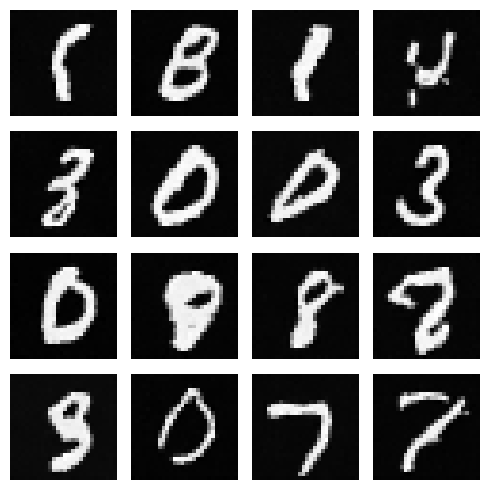

In [8]:
def generate_samples(model, scheduler, n_samples=16):
    """Generate MNIST samples from noise using the reverse process."""
    device = next(model.parameters()).device
    model.eval()

    # Start from random noise.
    x = torch.randn(n_samples, 1, 28, 28).to(device)

    with torch.no_grad():
        for step in tqdm(range(scheduler.num_timesteps - 1, -1, -1), desc="Sampling"):
            t = torch.full((n_samples,), step, device=device, dtype=torch.long)
            predicted_noise = model(x, t.float() / scheduler.num_timesteps)
            x = scheduler.reverse_step(x, step, predicted_noise)

    # Denormalize images from [-1, 1] to [0, 1].
    x = (x + 1) / 2
    return x.cpu()


def visualize_samples(samples, nrow=4):
    """Visualize generated samples in a grid."""
    plt.figure(figsize=(5, 5))
    for i in range(len(samples)):
        plt.subplot(nrow, nrow, i + 1)
        plt.imshow(samples[i, 0], cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# Generate and display samples.
samples = generate_samples(model, scheduler)
visualize_samples(samples)


## Visualizing Forward & Reverse Processes

The following functions help you visualize:
- **Forward Process:** How images get noisier.
- **Reverse Process:** How noise is gradually denoised into images.

Note: In the forward process, we use `generate_mnist` (instead of an undefined `load_mnist`).

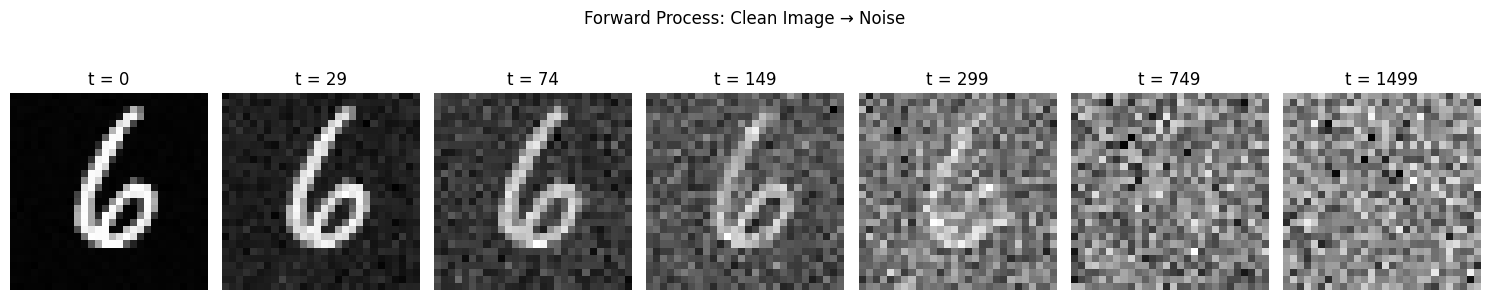

Sampling: 100%|██████████| 1500/1500 [00:12<00:00, 124.33it/s]


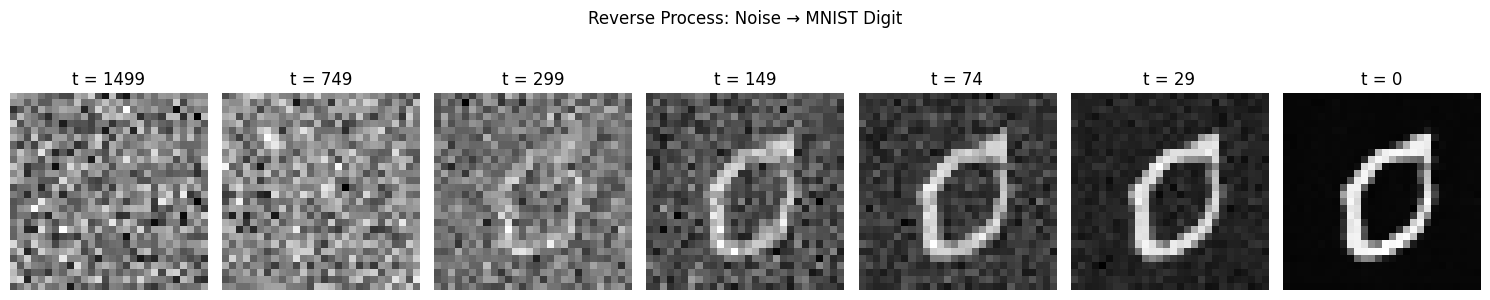

In [9]:
def visualize_forward_process(model, scheduler, n_samples=16):
    """
    Visualize how MNIST digits get progressively noisier in the forward process.
    """
    device = next(model.parameters()).device

    # Generate initial clean images.
    x_0 = generate_mnist(n_samples).to(device)

    max_timestep = scheduler.num_timesteps - 1
    plot_steps = [
        int(t)
        for t in [
            0,
            max_timestep * 0.02,
            max_timestep * 0.05,
            max_timestep * 0.1,
            max_timestep * 0.2,
            max_timestep * 0.5,
            max_timestep,
        ]
    ]

    fig, axes = plt.subplots(1, len(plot_steps), figsize=(15, 3))

    for idx, t in enumerate(plot_steps):
        timesteps = torch.full((n_samples,), t, device=device, dtype=torch.long)
        x_t, _ = scheduler.diffuse(x_0, timesteps)

        ax = axes[idx]
        # Display the first image of the batch at the selected timestep.
        img = x_t[0].detach().cpu()
        ax.imshow(img[0], cmap="gray")
        ax.set_title(f"t = {t}")
        ax.axis("off")

    plt.suptitle("Forward Process: Clean Image → Noise", y=1.05)
    plt.tight_layout()
    plt.show()


def visualize_reverse_process(model, scheduler, n_samples=16):
    """
    Visualize the reverse process: the gradual denoising of noise into an MNIST digit.
    """
    device = next(model.parameters()).device

    x = torch.randn(n_samples, 1, 28, 28).to(device)

    max_timestep = scheduler.num_timesteps - 1
    plot_steps = [
        int(t)
        for t in [
            max_timestep,
            max_timestep * 0.5,
            max_timestep * 0.2,
            max_timestep * 0.1,
            max_timestep * 0.05,
            max_timestep * 0.02,
            0,
        ]
    ]

    fig, axes = plt.subplots(1, len(plot_steps), figsize=(15, 3))

    with torch.no_grad():
        for step in tqdm(range(scheduler.num_timesteps - 1, -1, -1), desc="Sampling"):
            t = torch.full((n_samples,), step, device=device, dtype=torch.long)
            predicted_noise = model(x, t.float() / scheduler.num_timesteps)
            x = scheduler.reverse_step(x, step, predicted_noise)

            if step in plot_steps:
                idx = plot_steps.index(step)
                ax = axes[idx]
                img = x[0].detach().cpu()
                ax.imshow(img[0], cmap="gray")
                ax.set_title(f"t = {step}")
                ax.axis("off")

    plt.suptitle("Reverse Process: Noise → MNIST Digit", y=1.05)
    plt.tight_layout()
    plt.show()


# Visualize forward process:
visualize_forward_process(model, scheduler)

# Visualize reverse process:
visualize_reverse_process(model, scheduler)

Sampling: 100%|██████████| 1500/1500 [00:11<00:00, 125.39it/s]


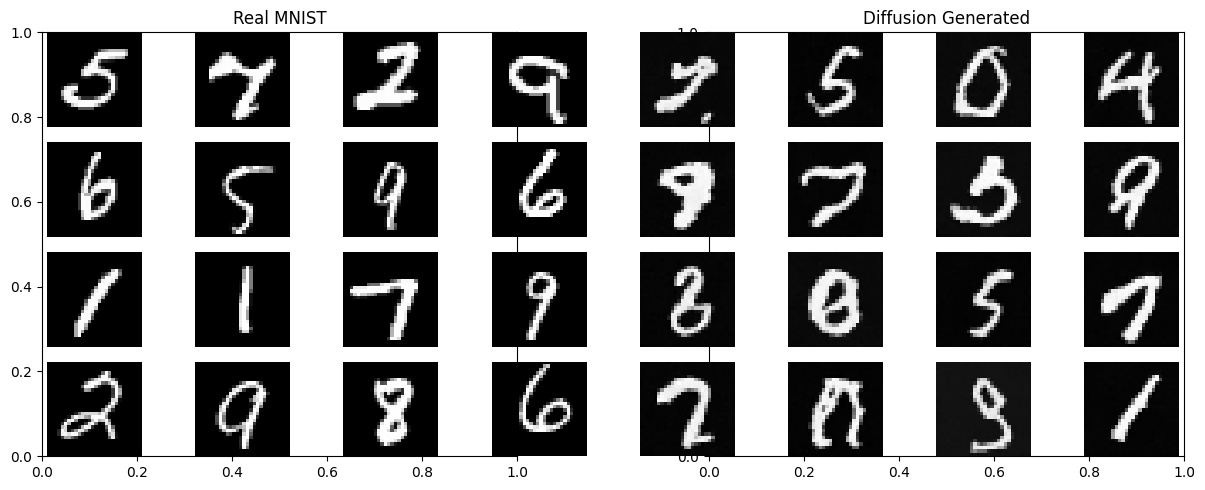

In [10]:
plt.figure(figsize=(12, 5))

# Plot real MNIST data.
plt.subplot(1, 2, 1)
real_data = generate_mnist(16)  # Fetch 16 real MNIST images.
plt.title("Real MNIST")
grid_size = int(np.sqrt(16))  # 4x4 grid.
for i in range(16):
    row = i // grid_size
    col = i % grid_size
    plt.subplot2grid((4, 8), (row, col))
    plt.imshow(real_data[i, 0], cmap="gray")
    plt.axis("off")

# Plot generated MNIST samples.
plt.subplot(1, 2, 2)
samples = generate_samples(model, scheduler, 16)
plt.title("Diffusion Generated")
for i in range(16):
    row = i // grid_size
    col = i % grid_size
    plt.subplot2grid((4, 8), (row, col + 4))  # Offset columns for side-by-side view.
    plt.imshow(samples[i, 0], cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Comparing Real and Generated MNIST Samples

Display real MNIST digits (from the generator) side-by-side with the generated samples.

## Your `To-Do`
 - Can you get the generated numbers closer to the real data?
 - Hint: Try increasing the number of timesteps in diffusion process. You can also try increasing the training steps, maybe play with the architecture a bit ...

Put your modified code, and images that show your improved samples, in a new cell below.


For extra credit, try adapting a GAN, VAE, Flow matching, or RealNVP to generate MNIST.

## Self-Attention

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        size = x.shape[-2:]
        x = x.flatten(2).transpose(1, 2)
        x = x + self.mha(self.ln(x), self.ln(x), self.ln(x))[0]
        x = x + self.ff_self(x)
        return x.transpose(1, 2).view(-1, x.shape[-1], size[0], size[1])

In [ ]:
class UpdatedResBlock(nn.Module):
    """Residual block with Conv layers for the MNIST diffusion model."""

    def __init__(self, in_c, out_c, is_res=False):
        super().__init__()
        self.is_res = is_res
        self.same_c = in_c == out_c
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),  # Convolution layer
            nn.BatchNorm2d(out_c),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.GELU(),
        )

        if in_c != out_c:
            self.shortcut = nn.Conv2d(in_c, out_c, 1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        x1 = self.conv1(x)  # First conv block
        x2 = self.conv2(x1)  # Second conv block
        if self.is_res:
            out = self.shortcut(x) + x2
            return out / math.sqrt(2)  # Scale residual output
        return x2

In [ ]:
class UpdatedDiffusionModel(nn.Module):
    """Diffusion model for MNIST with ConvNets, residual blocks, and time embedding."""

    def __init__(self, hidden_dim=128):
        super().__init__()

        self.time_embed = TimeEmbedding(hidden_dim)

        # Initial convolution transforms the input image channels into hidden_dim channels.
        self.input_conv = UpdatedResBlock(in_c=1, out_c=hidden_dim, is_res=True)

        # Downsampling layers (using convolutions with stride 2)
        self.down1 = nn.Sequential(
            UpdatedResBlock(hidden_dim, hidden_dim, is_res=True),
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.GELU(),
            nn.Dropout(p=0.2),
        )

        self.down2 = nn.Sequential(
            UpdatedResBlock(hidden_dim, hidden_dim, is_res=True),
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.GELU(),
            nn.Dropout(p=0.2),
        )

        # Bottleneck residual block
        self.bottleneck = nn.Sequential(
            UpdatedResBlock(hidden_dim, hidden_dim * 2, is_res=True),
            SelfAttention(hidden_dim * 2),
            UpdatedResBlock(hidden_dim * 2, hidden_dim, is_res=True),
        )

        # Upsampling with transpose convolutions and skip connections
        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(hidden_dim * 2, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.GELU(),
            nn.Dropout(p=0.2),
            UpdatedResBlock(hidden_dim, hidden_dim, is_res=True),
        )

        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(hidden_dim * 2, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.GELU(),
            nn.Dropout(p=0.2),
            UpdatedResBlock(hidden_dim, hidden_dim, is_res=True),
        )

        # Final convolution to map features back to one channel.
        self.output = nn.Conv2d(hidden_dim * 2, 1, 3, padding=1)

    def forward(self, x, t):
        # Compute time embedding and reshape to add spatial dimensions.
        t_emb = self.time_embed(t)
        t_emb = t_emb.view(-1, t_emb.shape[1], 1, 1)

        # Initial convolution with skip connection
        x1 = self.input_conv(x)
        x1 = x1 + t_emb  # Add time information

        # Downsample with added time embedding at each stage.
        x2 = self.down1(x1)
        x2 = x2 + t_emb
        x3 = self.down2(x2)
        x3 = x3 + t_emb

        # Bottleneck transformation
        x_bottleneck = self.bottleneck(x3)

        # Upsample, concatenating skip connections.
        # x = self.up2(torch.cat([x3, x3], dim=1))  # Using a dummy skip here
        x_up2 = self.up2(torch.cat([x_bottleneck, x3], dim=1))
        x_up1 = self.up1(torch.cat([x_up2, x2], dim=1))

        # Final output using skip connection from input
        out = self.output(torch.cat([x_up1, x1], dim=1))
        return out

In [ ]:
def train_diffusion(n_steps=10000, batch_size=128, lr=1e-3):
    """Train the diffusion model on MNIST data."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize MNIST diffusion model with convolutional architecture.
    model = UpdatedDiffusionModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    # Initialize noise scheduler.
    scheduler = DiffusionScheduler(num_timesteps=2000, device=device)

    losses = []
    pbar = tqdm(range(n_steps), desc="Training Diffusion")

    for step in pbar:
        # Get a batch of MNIST images.
        x_0 = generate_mnist(batch_size).to(device)
        # Sample random timesteps for the batch.
        t = torch.randint(0, scheduler.num_timesteps, (x_0.shape[0],)).to(device)
        # Apply forward process: add noise.
        x_t, noise = scheduler.diffuse(x_0, t)
        # Predict the noise using the model.
        predicted_noise = model(x_t, t.float() / scheduler.num_timesteps)
        # Compute loss (MSE between the predicted noise and the actual noise).
        loss = torch.mean((predicted_noise - noise) ** 2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        pbar.set_postfix({"loss": loss.item()})

    return model, losses, scheduler, device


# Train with a modest number of steps for demonstration:
model, losses, scheduler, device = train_diffusion(n_steps=5000)

## Visualizing Training Loss
plt.plot(losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

Sampling: 100%|██████████| 2000/2000 [00:32<00:00, 60.76it/s]


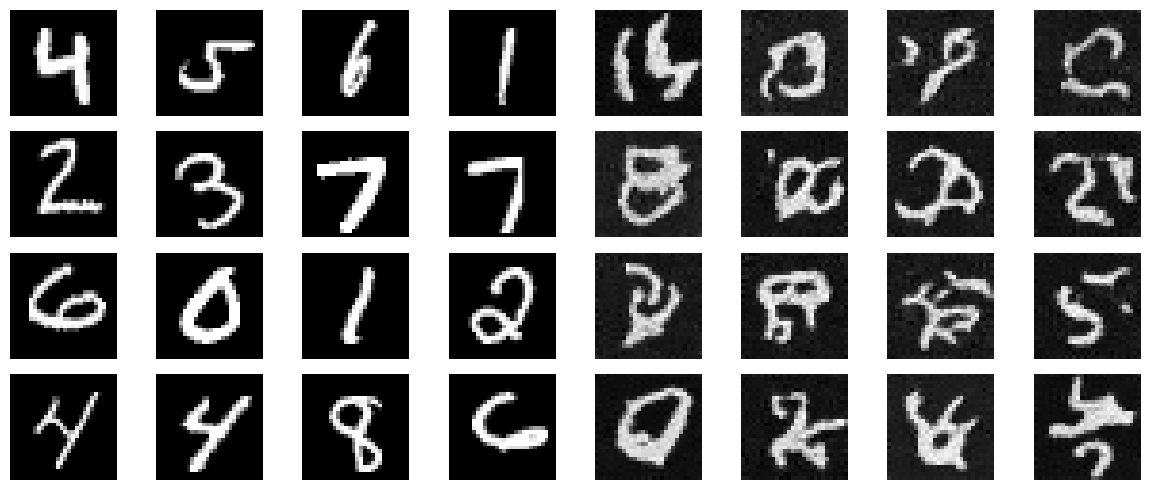

In [ ]:
plt.figure(figsize=(12, 5))

# Plot real MNIST data.
plt.subplot(1, 2, 1)
real_data = generate_mnist(16)  # Fetch 16 real MNIST images.
plt.title("Real MNIST")
grid_size = int(np.sqrt(16))  # 4x4 grid.
for i in range(16):
    row = i // grid_size
    col = i % grid_size
    plt.subplot2grid((4, 8), (row, col))
    plt.imshow(real_data[i, 0], cmap="gray")
    plt.axis("off")

# Plot generated MNIST samples.
plt.subplot(1, 2, 2)
samples = generate_samples(model, scheduler, 16)
plt.title("Diffusion Generated")
for i in range(16):
    row = i // grid_size
    col = i % grid_size
    plt.subplot2grid((4, 8), (row, col + 4))  # Offset columns for side-by-side view.
    plt.imshow(samples[i, 0], cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.show()

* A proper skip connection for x_3
* A self-attention block in the bottleneck layer.
* Use a separate convolution block as the skip connection when in_out dimensions unmatched.
* Dropouts after GELU.
* Upsamling Convolution blocks to replace Transpose Convolution.

### GAN Adaption

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


# First, properly define the function to load MNIST data
def generate_mnist(n_samples=None):
    """
    Load the MNIST dataset and transform it.
    n_samples: if specified, return only this many samples
    """
    # Transform: Convert PILImage to tensor and normalize to [-1, 1]
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),  # normalizes to [-1, 1]
        ]
    )

    # Download MNIST dataset
    mnist_dataset = datasets.MNIST(
        root="./data", train=True, download=True, transform=transform
    )

    # If n_samples is specified, create a subset
    if n_samples is not None and n_samples < len(mnist_dataset):
        indices = torch.randperm(len(mnist_dataset))[:n_samples]
        mnist_dataset = torch.utils.data.Subset(mnist_dataset, indices)

    return mnist_dataset


# Define Generator
class Generator(nn.Module):
    def __init__(self, latent_dim=100, channels=1):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        # Project and reshape
        self.init_size = 7  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size**2))

        # Upsampling layers with residual connections
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),  # Output range: [-1, 1]
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, channels=1):
        super(Discriminator, self).__init__()

        # Use spectral normalization for better stability
        def spectral_norm(layer):
            return nn.utils.spectral_norm(layer)

        self.model = nn.Sequential(
            spectral_norm(nn.Conv2d(channels, 32, 3, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            spectral_norm(nn.Conv2d(32, 64, 3, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            spectral_norm(nn.Conv2d(64, 128, 3, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            spectral_norm(nn.Conv2d(128, 256, 3, stride=1, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
        )

        # Output layer
        ds_size = 4
        self.adv_layer = nn.Sequential(
            nn.Linear(256 * ds_size * ds_size, 1), nn.Sigmoid()
        )

    def forward(self, img):
        features = self.model(img)
        features = features.view(features.shape[0], -1)
        validity = self.adv_layer(features)
        return validity


def initialize_weights(model):
    """Initialize weights for better GAN training"""
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)


# Training function with improvements for quality
def train_gan(
    generator,
    discriminator,
    dataloader,
    epochs=100,
    latent_dim=100,
    save_interval=100,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
    # Loss function and optimizers
    adversarial_loss = nn.BCELoss()

    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # Learning rate scheduler for stabilization
    scheduler_G = optim.lr_scheduler.CosineAnnealingLR(
        optimizer_G, epochs, eta_min=1e-5
    )
    scheduler_D = optim.lr_scheduler.CosineAnnealingLR(
        optimizer_D, epochs, eta_min=1e-5
    )

    # Track metrics
    g_losses, d_losses = [], []
    fixed_noise = torch.randn(16, latent_dim, device=device)  # For visualization

    # Training loop
    for epoch in range(epochs):
        epoch_g_loss, epoch_d_loss = 0, 0
        n_batches = 0

        for i, (real_imgs, _) in enumerate(dataloader):
            n_batches += 1
            batch_size = real_imgs.size(0)

            # Configure input
            real_imgs = real_imgs.to(device)

            # -----------------
            #  Train Discriminator
            # -----------------

            optimizer_D.zero_grad()

            # Adversarial ground truths with label smoothing
            valid = torch.ones(batch_size, 1, device=device) * 0.9  # Label smoothing
            fake = torch.zeros(batch_size, 1, device=device)

            # Sample noise and generate a batch of fake images
            z = torch.randn(batch_size, latent_dim, device=device)
            fake_imgs = generator(z)

            # Measure discriminator's ability on real and fake images
            real_pred = discriminator(real_imgs)
            fake_pred = discriminator(fake_imgs.detach())

            real_loss = adversarial_loss(real_pred, valid)
            fake_loss = adversarial_loss(fake_pred, fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Generate a batch of images
            fake_imgs = generator(z)

            # Train on discriminator's response
            validity = discriminator(fake_imgs)
            g_loss = adversarial_loss(validity, valid)

            g_loss.backward()
            optimizer_G.step()

            # Track metrics
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()

        print(
            f"[Epoch {epoch}/{epochs}]"
            f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]"
        )
        # Step the learning rate schedulers
        scheduler_G.step()
        scheduler_D.step()

        # Record average epoch losses
        g_losses.append(epoch_g_loss / n_batches)
        d_losses.append(epoch_d_loss / n_batches)

        # Save images at intervals
        if (epoch + 1) % (epochs // 10) == 0 or epoch == 0:
            save_sample_images(epoch, generator, fixed_noise, device)

    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label="Generator Loss")
    plt.plot(d_losses, label="Discriminator Loss")
    plt.legend()
    plt.title("GAN Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.savefig("gan_loss_curve.png")
    plt.show()

    return generator, discriminator, g_losses, d_losses


def save_sample_images(epoch, generator, fixed_noise, device, n_rows=4, n_cols=4):
    """Generate and save sample images during training"""
    generator.eval()
    with torch.no_grad():
        gen_imgs = generator(fixed_noise).detach().cpu()

    # Rescale images from [-1, 1] to [0, 1]
    gen_imgs = (gen_imgs + 1) / 2.0

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(8, 8))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    for i, ax in enumerate(axs.flat):
        if i < gen_imgs.size(0):
            ax.imshow(gen_imgs[i, 0], cmap="gray")
        ax.axis("off")

    plt.savefig(f"mnist_gan_epoch_{epoch}.png")
    plt.close(fig)
    generator.train()


# Set up DataLoader with MNIST dataset
def setup_mnist_gan_training(batch_size=128, latent_dim=100, epochs=100):
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Create models and initialize weights
    generator = Generator(latent_dim).to(device)
    discriminator = Discriminator().to(device)
    initialize_weights(generator)
    initialize_weights(discriminator)

    # Get MNIST dataset and create dataloader
    mnist_dataset = generate_mnist()  # Get the dataset
    dataloader = DataLoader(
        mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True
    )

    # Train the GAN
    gen, disc, g_losses, d_losses = train_gan(
        generator,
        discriminator,
        dataloader,
        epochs=epochs,
        latent_dim=latent_dim,
        device=device,
    )

    return gen, disc, g_losses, d_losses


# Function to compare real vs generated samples
def compare_real_vs_generated(
    generator,
    n_samples=10,
    latent_dim=100,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
    """Generate samples and compare with real data"""
    generator.eval()

    # Get real samples
    test_dataset = datasets.MNIST(
        root="./data",
        train=False,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
        ),
    )

    # Get n random test samples
    indices = torch.randperm(len(test_dataset))[:n_samples]
    real_samples = []
    for idx in indices:
        img, _ = test_dataset[idx]
        real_samples.append(img)
    real_samples = torch.stack(real_samples)

    # Generate fake samples
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim, device=device)
        fake_samples = generator(z).detach().cpu()

    # Rescale samples from [-1, 1] to [0, 1]
    real_samples = (real_samples + 1) / 2.0
    fake_samples = (fake_samples + 1) / 2.0

    # Plot comparison
    fig, axs = plt.subplots(2, n_samples, figsize=(15, 5))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    # Plot real samples
    for i in range(n_samples):
        axs[0, i].imshow(real_samples[i, 0], cmap="gray")
        axs[0, i].axis("off")
        if i == 0:
            axs[0, i].set_title("Real", fontsize=18, loc="left")

    # Plot generated samples
    for i in range(n_samples):
        axs[1, i].imshow(fake_samples[i, 0], cmap="gray")
        axs[1, i].axis("off")
        if i == 0:
            axs[1, i].set_title("Generated", fontsize=18, loc="left")

    plt.tight_layout()
    plt.savefig("mnist_real_vs_generated.png")
    plt.show()
    generator.train()

Using device: cuda
[Epoch 0/50][D loss: 0.6725] [G loss: 0.8075]
[Epoch 1/50][D loss: 0.6583] [G loss: 0.8191]
[Epoch 2/50][D loss: 0.6818] [G loss: 0.8603]
[Epoch 3/50][D loss: 0.6664] [G loss: 0.8955]
[Epoch 4/50][D loss: 0.6290] [G loss: 0.8934]
[Epoch 5/50][D loss: 0.6537] [G loss: 0.9248]
[Epoch 6/50][D loss: 0.6438] [G loss: 0.9306]
[Epoch 7/50][D loss: 0.6350] [G loss: 0.8843]
[Epoch 8/50][D loss: 0.6355] [G loss: 0.9124]
[Epoch 9/50][D loss: 0.6386] [G loss: 0.9058]
[Epoch 10/50][D loss: 0.6257] [G loss: 0.9131]
[Epoch 11/50][D loss: 0.6720] [G loss: 0.9126]
[Epoch 12/50][D loss: 0.6481] [G loss: 0.9457]
[Epoch 13/50][D loss: 0.6387] [G loss: 0.9214]
[Epoch 14/50][D loss: 0.6459] [G loss: 0.9195]
[Epoch 15/50][D loss: 0.6629] [G loss: 0.8836]
[Epoch 16/50][D loss: 0.6320] [G loss: 0.8859]
[Epoch 17/50][D loss: 0.6591] [G loss: 0.9532]
[Epoch 18/50][D loss: 0.6351] [G loss: 0.9012]
[Epoch 19/50][D loss: 0.6651] [G loss: 0.8850]
[Epoch 20/50][D loss: 0.6243] [G loss: 0.8877]
[Epo

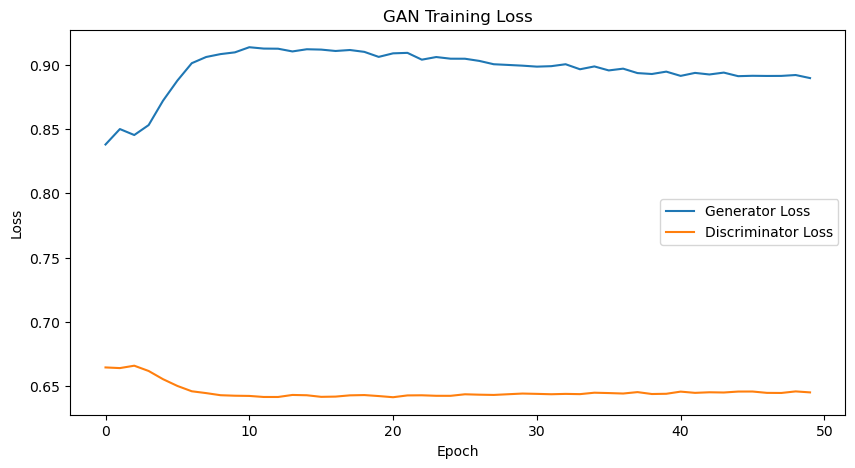

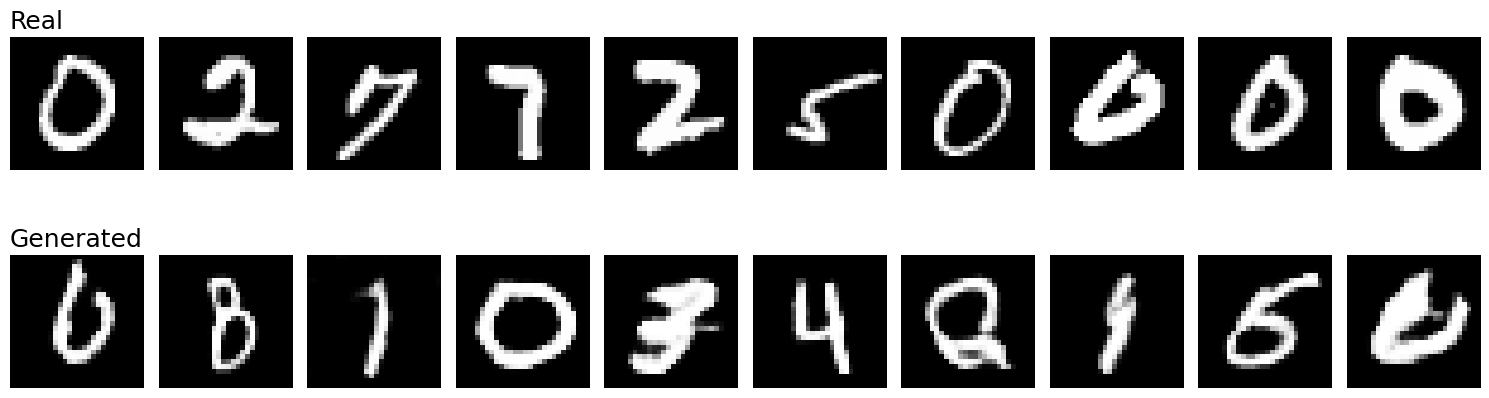

In [ ]:
# Train the GAN model with fewer epochs for demonstration
generator, discriminator, g_losses, d_losses = setup_mnist_gan_training(
    batch_size=128,
    latent_dim=100,
    epochs=50,  # Use more epochs (100-200) for production quality
)

# Compare real samples with generated samples
compare_real_vs_generated(generator, n_samples=10)

### VAE Adaption

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder: Input shape (batch, 1, 28, 28)
        self.enc_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU(),
        )
        # Flattened feature size: 64*7*7 = 3136
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

        # Decoder: First project latent dim to feature map
        self.fc_dec = nn.Linear(latent_dim, 64 * 7 * 7)
        self.dec_conv = nn.Sequential(
            nn.ConvTranspose2d(
                64, 32, kernel_size=4, stride=2, padding=1
            ),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(
                32, 1, kernel_size=4, stride=2, padding=1
            ),  # 14x14 -> 28x28
            nn.Sigmoid(),  # Outputs in the range [0, 1]
        )

    def encode(self, x):
        h = self.enc_conv(x)
        h = h.view(x.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(z.size(0), 64, 7, 7)
        x_recon = self.dec_conv(h)
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


# Define the VAE loss: reconstruction loss + KL divergence
def loss_function(x_recon, x, mu, logvar):
    BCE = F.binary_cross_entropy(x_recon, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


# Training loop for the VAE
def train_vae(
    model,
    dataloader,
    epochs=10,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    train_losses = []

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (x, _) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            x_recon, mu, logvar = model(x)
            loss = loss_function(x_recon, x, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader.dataset)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
        train_losses.append(avg_loss)

    return train_losses


# Function to generate images by sampling from the latent space
def generate_samples(
    model,
    n_samples=16,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, model.latent_dim).to(device)
        samples = model.decode(z)
    return samples


# Plot generated images in a grid
def plot_generated_images(samples, n_rows=4, n_cols=4):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
    for i, ax in enumerate(axs.flat):
        if i < samples.size(0):
            ax.imshow(samples[i].cpu().squeeze(), cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    plt.show()


# Function to load MNIST data
def generate_mnist(n_samples=None):
    transform = transforms.Compose([transforms.ToTensor()])
    mnist_dataset = datasets.MNIST(
        root="./data", train=True, download=True, transform=transform
    )
    if n_samples is not None and n_samples < len(mnist_dataset):
        indices = torch.randperm(len(mnist_dataset))[:n_samples]
        mnist_dataset = torch.utils.data.Subset(mnist_dataset, indices)
    return mnist_dataset


# Setup function to create the dataloader and model
def setup_vae_training(batch_size=128, latent_dim=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataset = generate_mnist()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = VAE(latent_dim=latent_dim).to(device)
    return model, dataloader, device

Epoch 1/10 - Loss: 155.6174
Epoch 2/10 - Loss: 114.5836
Epoch 3/10 - Loss: 109.9107
Epoch 4/10 - Loss: 107.7585
Epoch 5/10 - Loss: 106.5153
Epoch 6/10 - Loss: 105.6643
Epoch 7/10 - Loss: 105.0190
Epoch 8/10 - Loss: 104.3906
Epoch 9/10 - Loss: 103.9345
Epoch 10/10 - Loss: 103.5301


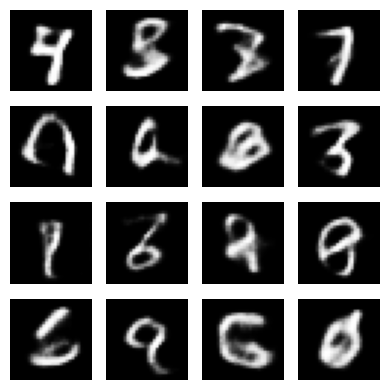

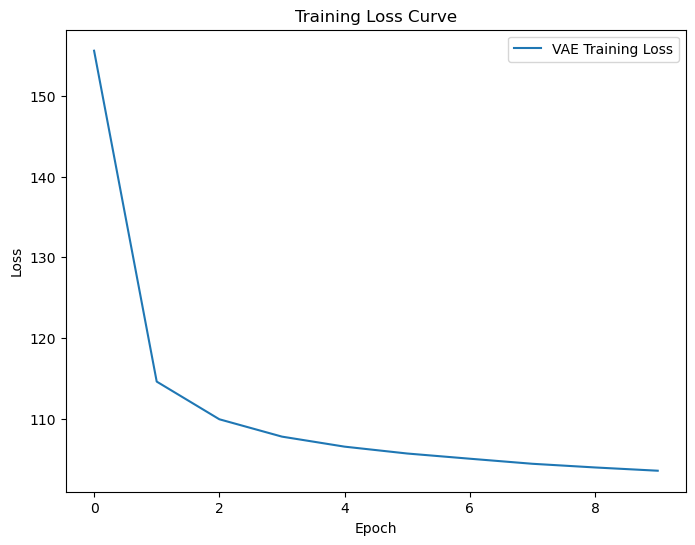

In [ ]:
latent_dim = 20
epochs = 10

model, dataloader, device = setup_vae_training(batch_size=128, latent_dim=latent_dim)
train_losses = train_vae(model, dataloader, epochs=epochs, device=device)

# Generate and display samples after training is finished
samples = generate_samples(model, n_samples=16, device=device)
plot_generated_images(samples)

# Plot training loss curve
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="VAE Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Curve")
plt.show()